In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


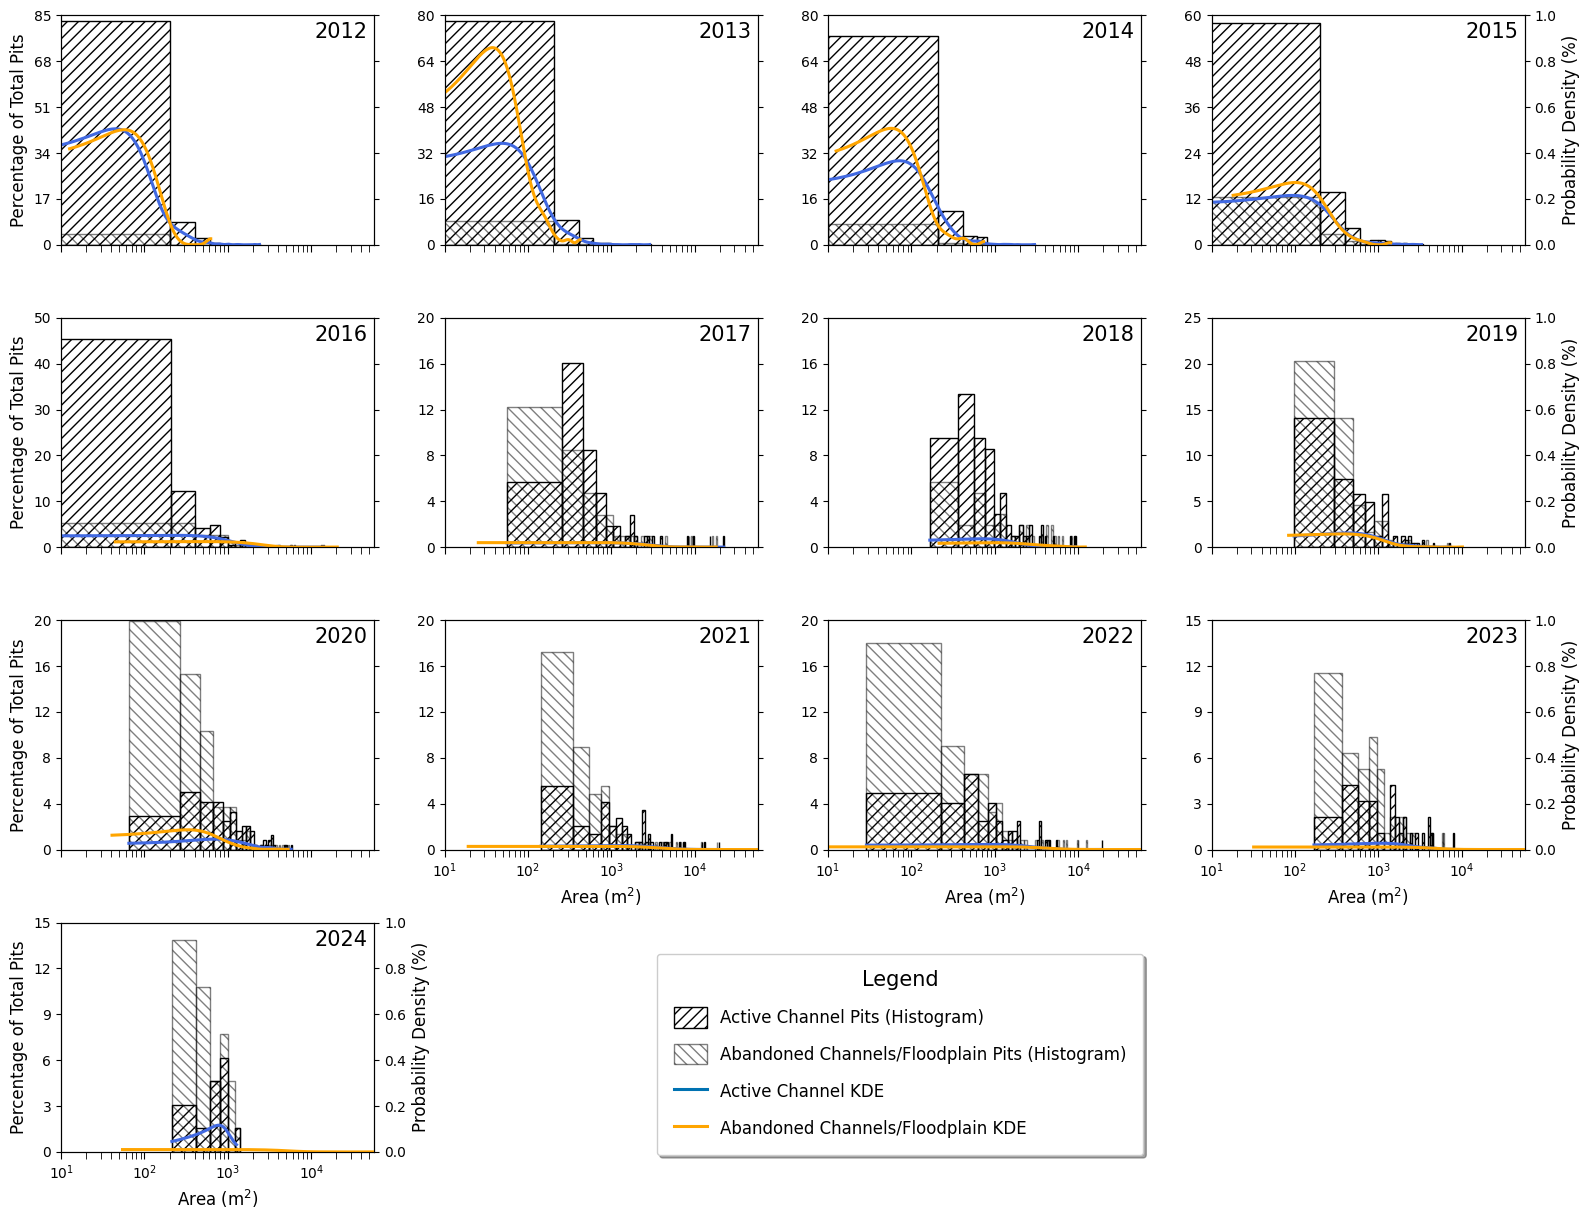

Figure saved successfully at /content/drive/My Drive/colab/fig7_pdfs/fig7_pdfs.png


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
from matplotlib.ticker import ScalarFormatter, FuncFormatter, LogLocator

# Grayscale palette for histograms, and updated colors for KDE curves (blue for channel, red for floodplain)
hist_colors = ['none', 'none']  # No fill color for channel and floodplain pits
kde_colors = ['royalblue', 'orange']  # Royal Blue for channel KDE, Orange for floodplain KDE

# Define the base file path for the pits Excel files
base_path = '/content/drive/My Drive/colab/fig7_pdfs/'

# Define the years range
years = range(2012, 2025)

# Set the number of rows and columns for the grid of plots
nrows = 4
ncols = 4

# Define consistent x-axis limits for log scale (covering the range of pit areas)
x_limits = (10, 57000)  # Set limits between 10 and 57000 for the log scale

# Define dictionaries for specific y-axis limits
primary_y_axis_limits = {
    2012: 85, 2013: 80, 2014: 80, 2015: 60, 2016: 50,
    2017: 20, 2018: 20, 2019: 25, 2020: 20, 2021: 20,
    2022: 20, 2023: 15, 2024: 15
}
default_primary_y_limit = 12

secondary_y_axis_limits = {
    #2015: 1, 2019: 1, 2023: 1, 2024: 1  # Required years with percentage values
}
default_secondary_y_limit = 0.01

# Create a grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12.3))
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

# Adjust subplot spacing
plt.subplots_adjust(
    wspace=0.01,  # Space between columns (reduce for tighter layout)
    hspace=0.01  # Space between rows (reduce for tighter layout)
)

# Define a custom formatter function for powers of 10 on the x-axis
def log_10_product(x, pos):
    return r'$10^{{{}}}$'.format(int(np.log10(x)))

# Loop over the years and create a plot for each year
for i, year in enumerate(years):
    # Generate the full file path for each year
    file_path = os.path.join(base_path, f'pits_{year}.xlsx')

    # Check if the file exists before proceeding
    if not os.path.exists(file_path):
        print(f"File for year {year} not found. Skipping.")
        continue

    # Load the Excel file (using sheet index 2, which refers to the 3rd sheet in Excel)
    df = pd.read_excel(file_path, sheet_name=2)

    # Extract the 'area_c (sqm)' (channel pits) and 'area_fp (sqm)' (floodplain pits) column data
    area_channel = df['area_c (sqm)'].dropna()  # Remove NaN values
    area_floodplain = df['area_fp (sqm)'].dropna()  # Remove NaN values

    # Combine both datasets for total pits
    combined_total_pits = len(area_channel) + len(area_floodplain)

    # Define the constant bin width in linear space for this specific year
    bin_width = 200  # Set a desired bin width (in linear space)
    bins = np.arange(start=area_channel.min(), stop=area_channel.max() + bin_width, step=bin_width)

    # Get the axis for the current plot
    ax1 = axes[i]

    # Plot the histogram for channel pits
    ax1.hist(area_channel, bins=bins, density=False, weights=np.ones_like(area_channel) / combined_total_pits * 100,
             edgecolor='black', facecolor=hist_colors[0], alpha=1.0, hatch='///')  # Hatch for channel pits

    # Plot the histogram for floodplain pits
    ax1.hist(area_floodplain, bins=bins, density=False, weights=np.ones_like(area_floodplain) / combined_total_pits * 100,
             edgecolor='black', facecolor=hist_colors[1], alpha=0.5, hatch='\\\\\\')  # Hatch for floodplain pits

    # Set the primary y-axis for percentage of total pits
    if year in [2012, 2016, 2020, 2024]:  # Add primary y-axis labels for these years only
        ax1.set_ylabel('Percentage of Total Pits', fontsize=12)
    ax1.set_xlabel('Area (sqm)', fontsize=12)
    ax1.set_xscale('log')  # Set x-axis to logarithmic scale

    # Apply primary y-axis limit from dictionary if available, else use the default
    ax1.set_ylim(0, primary_y_axis_limits.get(year, default_primary_y_limit))

    # Set primary y-axis ticks to rounded values
    max_y = primary_y_axis_limits.get(year, default_primary_y_limit)
    round_ticks = np.arange(0, max_y + 1, max_y // 5)  # Define evenly spaced rounded ticks
    ax1.set_yticks(round_ticks)


    # Set consistent x-axis limits for all plots
    ax1.set_xlim(x_limits)

    # Set the custom formatter for the x-axis ticks to powers of 10
    ax1.xaxis.set_major_locator(LogLocator(base=10.0))
    ax1.xaxis.set_major_formatter(FuncFormatter(log_10_product))

    # Create a secondary y-axis for the KDE
    ax2 = ax1.twinx()

    # Add KDE for channel pits
    kde_channel = gaussian_kde(area_channel)
    x_channel = np.linspace(area_channel.min(), area_channel.max(), 1000)
    ax2.plot(x_channel, kde_channel(x_channel) * 100, color=kde_colors[0], linestyle='-', linewidth=2.2)  # Convert to percentage

    # Add KDE for floodplain pits
    kde_floodplain = gaussian_kde(area_floodplain)
    x_floodplain = np.linspace(area_floodplain.min(), area_floodplain.max(), 1000)
    ax2.plot(x_floodplain, kde_floodplain(x_floodplain) * 100, color=kde_colors[1], linestyle='-', linewidth=2.2)  # Convert to percentage

    # Apply secondary y-axis limit from dictionary if available, else use the default
    ax2.set_ylim(0, secondary_y_axis_limits.get(year, default_secondary_y_limit) * 100)
    if year in [2015, 2019, 2023, 2024]:
        ax2.set_ylabel('Probability Density (%)', fontsize=12)

    # Remove secondary y-axis labels except for 2015, 2019, 2023, and 2024
    if year not in [2015, 2019, 2023, 2024]:
        ax2.tick_params(axis='y', which='both', labelright=False)  # Hide secondary y-axis labels


    # Add title text inside each subplot
    ax1.text(
    0.81, 0.97,  # Adjust the position as desired (x, y in subplot coordinates where bottom-left is (0, 0) and top-right is (1, 1))
    f'{year}',  # The year as the title
    fontsize=15,  # Font size
    ha='left',  # Horizontal alignment (can be 'left', 'center', or 'right')
    va='top',  # Vertical alignment (can be 'top', 'center', or 'bottom')
    transform=ax1.transAxes  # Ensures the text is placed relative to the subplot axes
    )


    # Configure X-Axis for Subplots
    if year in [2021, 2022, 2023, 2024]:
    # Keep x-axis label and tick labels for these subplots
      ax1.set_xlabel(r'Area (m$^2$)', fontsize=12)  # Add x-axis label with m²
      ax1.tick_params(axis='x', which='both', length=5, labelbottom=True)  # Ticks and tick labels
    else:
    # Remove x-axis label and tick labels for all other subplots
      ax1.set_xlabel('')  # Remove x-axis label
      ax1.tick_params(axis='x', which='both', length=5, labelbottom=False)  # Keep ticks but remove tick labels



# Remove the extra empty plots
for j in range(len(years), nrows * ncols):
    fig.delaxes(axes[j])

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Custom legend elements for the histogram and KDE styles
legend_elements = [
    # Histograms (hatching for channel and floodplain)
    Patch(facecolor='none', edgecolor='black', hatch='///', label='Active Channel Pits (Histogram)'),  # Diagonal hatch for channel
    Patch(facecolor='none', edgecolor='black', hatch='\\\\\\', alpha=0.5, label='Abandoned Channels/Floodplain Pits (Histogram)'),  # Opposite diagonal hatch for floodplain

    # KDE lines
    Line2D([0], [0], color='#0072B2', linestyle='-', linewidth=2.2, label='Active Channel KDE'),  # Solid blue line
    Line2D([0], [0], color='orange', linestyle='-', linewidth=2.2, label='Abandoned Channels/Floodplain KDE')  # Dashed red line
]

# Add the legend in the empty space (bottom right) with a title
fig.legend(
    handles=legend_elements,
    loc='lower right',
    bbox_to_anchor=(0.723, 0.05),  # Position the legend in the empty space
    fontsize=12,  # Increase legend text size
    frameon=True,
    shadow=True,
    fancybox=True,
    title="Legend",  # Add a title
    title_fontsize=15,  # Increase the title font size
    labelspacing=1,  # Increase spacing between legend items
    borderpad=1,  # Increase padding around the legend content
    handlelength=2,  # Increase the length of the line handles
    handleheight=1.5  # Increase the height of the patch handles
)



# Adjust layout to prevent overlap
plt.tight_layout()

# Define the file path to save the plot
output_file_path = '/content/drive/My Drive/colab/fig7_pdfs/fig7_pdfs.png'

# Save the figure in high quality
fig.savefig(output_file_path, dpi=1200, bbox_inches='tight', format='png')

# Show the plot
plt.show()

print(f"Figure saved successfully at {output_file_path}")
